### U-Net Ship Detection 

#### Spotting ships in a Satellite image and highlight it

In [1]:
import os
import sys
import random
import warnings #
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './onlyships128/'
VAL_PATH = './onlyshipsmasks128/' #os.path.join(ppp,'U_NET/train/')
TEST_PATH = './onlyships128/'#os.path.join(ppp,'U_NET/validation/')

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Collect our file names for training and test date

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]
val_ids=next(os.walk(VAL_PATH))[2]

In [3]:
print(len(val_ids))

1008


#### Creating our image masks of dimension 128 x 128 (black images)

In [4]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()

# for n, id_ in tqdm(enumerate(val_ids), total=len(train_ids)):
#     path = TRAIN_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img=imread('./onlyships128/'+id_+'.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
#     # Now we take all masks associated with that image and combine them into one single mask
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
#     # Y_train is now our single mask associated with our image
#     Y_train[n] = mask

for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    img=imread('./onlyships128/'+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask=imread('./onlyshipsmasks128/'+id_)[:,:]
    Y_train[n]=mask.reshape(IMG_HEIGHT,IMG_WIDTH,1)
    
    
# Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
X_test = X_train[:10]
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:21<00:00, 47.24it/s]

Getting and resizing test images ... 
Done!


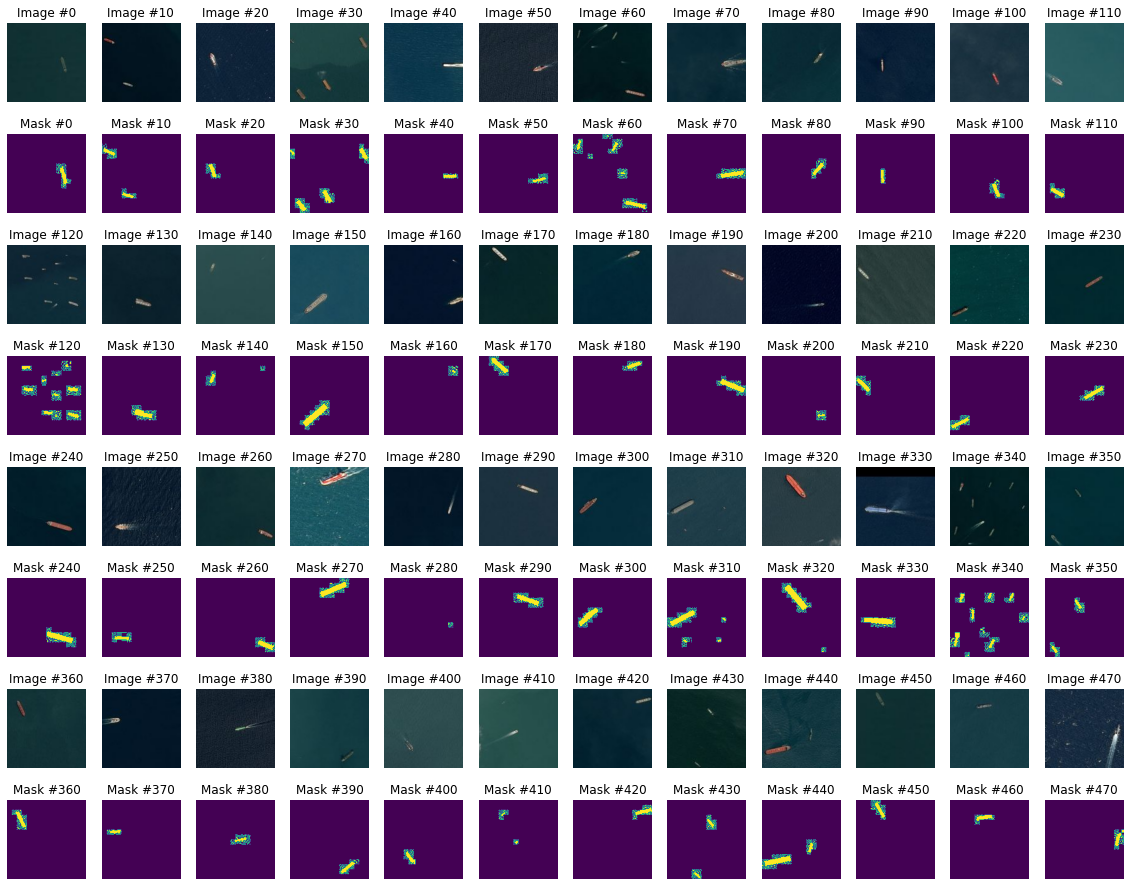

In [5]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

# Output 

Ship found


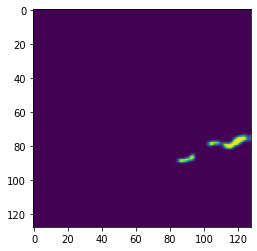

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL.Image import open

import warnings
warnings.filterwarnings('ignore')

model = load_model('./new-UNET/model_cp308.h5')

# model.summary()

# Please mention the image file location below

imageLoc="F:/zip/airbus-ship-detection/OriginalData/test_v2/0c5e35213.jpg"

image=open(imageLoc)
image=image.resize((128,128))

imagearr=np.array([img_to_array(image)/255.0])
output = model.predict(imagearr)

hasShip=0


if len(np.where(output==1))>0:
    print("Ship found")
    outputimage = array_to_img(output[0]*255.0)
    plt.imshow(outputimage)
    hasShip=1
else:
    print("No ship detetcted")

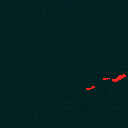

In [7]:
from PIL import Image

from IPython.display import display, clear_output
def displayoutput():
    if hasShip==1:
        image =cv2.imread(imageLoc)
        image.resize((128,128,3))
        image[:,:,2]=np.where(output[0,:,:,0]>0.5,
                      255,image[:, :,2])
        # convert color from CV2 BGR back to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(image))
    else:
        print("No ship")
    
displayoutput()

In [2]:
model = load_model('./new-UNET/model_cp308.h5')

C:\Users\Nilesh\miniconda3\envs\tf241\lib\site-packages\tensorflow\python\keras\layers\core.py:1057: UserWarning: modelUNET is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [3]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=192)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [4]:
!pip install pydot